# C247 Final Project: EEG Subject Action Classification

This Notebook is for the Final Project of EEG Action Subject Classification for the 2024 Winter Quarter Course offering of C247: Deep Learning and Neural Networks taught by Professor **[Jonathan Kao](https://seas.ucla.edu/~kao/people_dir/jonathan_kao.html)**

**Authors:** **[Timothy Do (ID: 406302424)](https://timothydo.me)**

## Setup

This project will be training an EEG Action Subject Classifier in accordance with the **[BCI Competition](https://www.bbci.de/competition/)** and its data. The task is classifying a certain action (out of a possible 4) with 22 ECG signals using certain convolutional neural network (CNN) and recurrent neural network (RNN) architectures.

Note: The dataset has been filtered such that it is directly importable using the numpy package, 3 ECG channels regarding eye movement are removed, and all **NaN** trials are removed.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from keras.utils import to_categorical

%load_ext autoreload

In [2]:
# Data Loading
data_dir = 'project_data/project'
if(not(os.path.exists(data_dir))):
    print('Please Download and Unzip \"project_data.zip\" and Try Again.')

# Load Test Data
X_test = np.load(f"{data_dir}/X_test.npy")
y_test = np.load(f"{data_dir}/y_test.npy")
person_train_valid = np.load(f"{data_dir}/person_train_valid.npy")
X_train_valid = np.load(f"{data_dir}/X_train_valid.npy")
y_train_valid = np.load(f"{data_dir}/y_train_valid.npy")
person_test = np.load(f"{data_dir}/person_test.npy")

# Verifying Data was Loaded Correctly
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Data Visualization: Exploring the Dataset

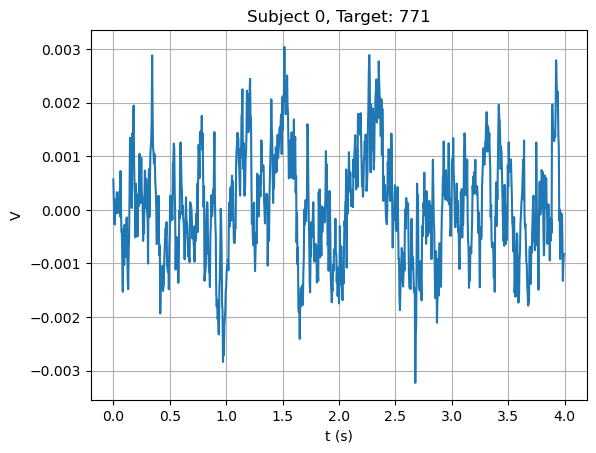

In [3]:
# Data Visualizaiton
subject = int(person_train_valid[0][0])
target = int(y_train_valid[0])
plt.figure()

# Sampled at 250 Hz
plt.plot(np.arange(1000)/250,X_train_valid[0,0,:]*(100*10**-6))
plt.xlabel('t (s)');
plt.ylabel('V');
plt.title(f'Subject {subject}, Target: {target}')
plt.grid()

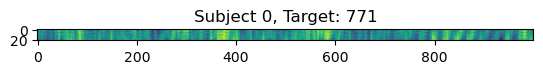

In [4]:
# Visualizing Data as an Image
plt.imshow(X_train_valid[0])
plt.title(f'Subject {subject}, Target: {target}')
plt.show()

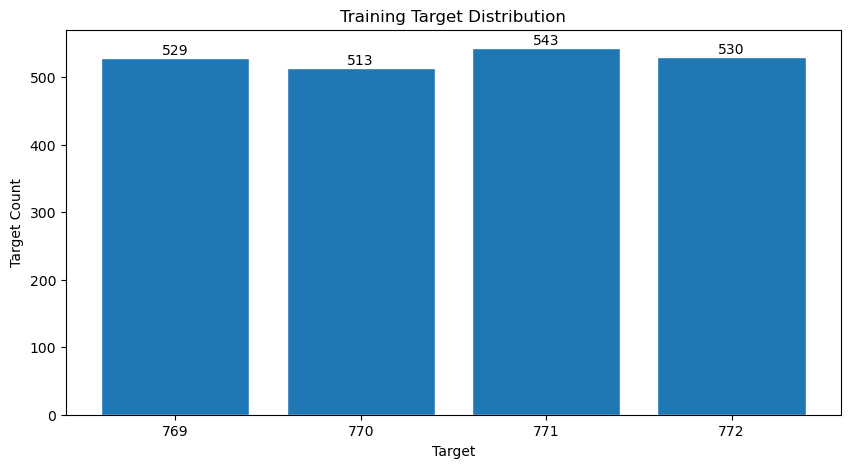

In [5]:
# Label Distributions for Training Target Data
plt.figure(figsize=(10,5))
labels, counts = np.unique(y_train_valid, return_counts=True)
labels = [str(label) for label in labels]
trainTitle = plt.title('Training Target Distribution')
trainXLabel = plt.xlabel('Target')
trainYLabel = plt.ylabel('Target Count')
trainBar = plt.bar(labels,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

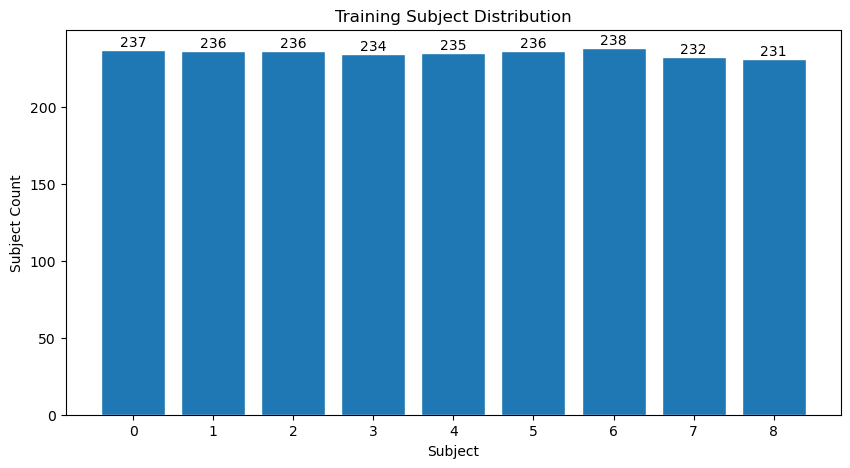

In [6]:
# Label Distributions for Training Person Data
plt.figure(figsize=(10,5))
labels, counts = np.unique(person_train_valid, return_counts=True)
labels = [str(int(label)) for label in labels]
trainTitle = plt.title('Training Subject Distribution')
trainXLabel = plt.xlabel('Subject')
trainYLabel = plt.ylabel('Subject Count')
trainBar = plt.bar(labels,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

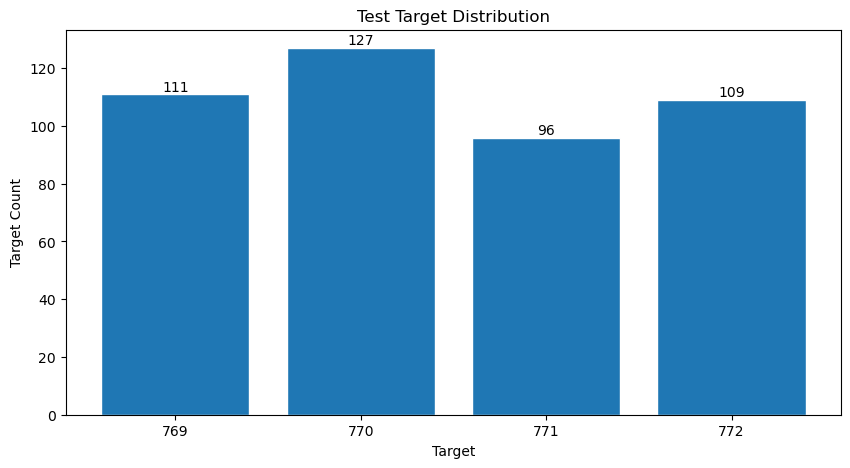

In [7]:
# Label Distributions for Test Target Data
plt.figure(figsize=(10,5))
labels, counts = np.unique(y_test, return_counts=True)
labels = [str(label) for label in labels]
trainTitle = plt.title('Test Target Distribution')
trainXLabel = plt.xlabel('Target')
trainYLabel = plt.ylabel('Target Count')
trainBar = plt.bar(labels,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

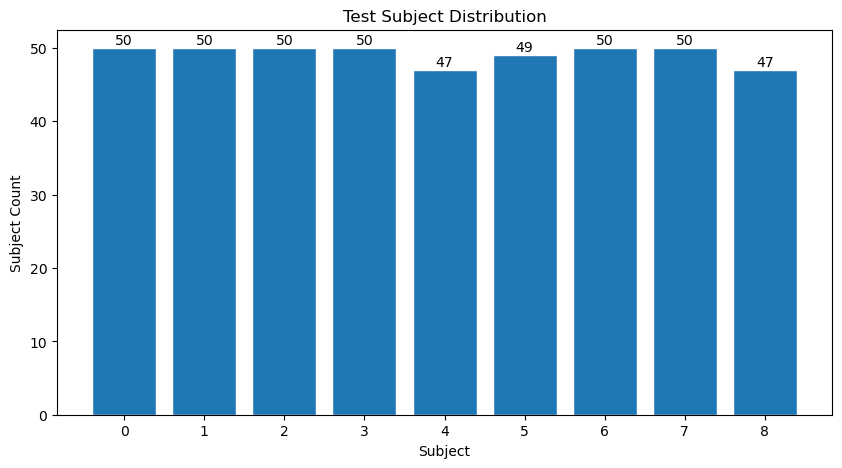

In [8]:
# Label Distributions for Training Person Data
plt.figure(figsize=(10,5))
labels, counts = np.unique(person_test, return_counts=True)
labels = [str(int(label)) for label in labels]
trainTitle = plt.title('Test Subject Distribution')
trainXLabel = plt.xlabel('Subject')
trainYLabel = plt.ylabel('Subject Count')
trainBar = plt.bar(labels,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

## Neural Network Architectures

### Device Configuration

In [9]:
# Setup PyTorch Device (Assuming only Single Device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
gpuName = f'({torch.cuda.get_device_name(device)})' if torch.cuda.is_available() else ''
print(f'Using PyTorch Backend: {device} {gpuName}')

Using PyTorch Backend: cpu 


In [10]:
# Setup PyTorch Device (Assume Mac M-Series Chip)

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device('mps')
    print(f'Using PyTorch Backend: {device}')

Using PyTorch Backend: mps


### Convolutional Neural Networks (CNNs)

#### 1. Basic CNN (Discussion #6)

In [11]:
from models.BasicCNN import BasicCNN
print(BasicCNN())

BasicCNN(
  (ConvBlock1): Sequential(
    (0): Conv2d(22, 25, kernel_size=(10, 1), stride=(1, 1), padding=(5, 0))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (ConvBlock2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), padding=(5, 0))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (ConvBlock3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), padding=(5, 0))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (ConvBlock4): Sequential(
    (0): Conv2d(100, 200, kernel_size=(10, 1), stride=(1, 1), padding=(5, 0

### 2. Basic CNN2D

In [12]:
from models.BasicCNN2D import BasicCNN2D
print(BasicCNN2D())

BasicCNN2D(
  (ConvBlock1): Sequential(
    (0): Conv2d(22, 25, kernel_size=(10, 10), stride=(1, 1), padding=(5, 0))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (ConvBlock2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(10, 10), stride=(1, 1), padding=(5, 0))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (ConvBlock3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(10, 10), stride=(1, 1), padding=(5, 0))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (ConvBlock4): Sequential(
    (0): Conv2d(100, 200, kernel_size=(10, 10), stride=(1, 1), padding

### 3. HybridCNNLSTM

In [13]:
from models.HybridCNNLSTM import HybridCNNLSTM
print(HybridCNNLSTM())

HybridCNNLSTM(
  (conv_block1): Sequential(
    (0): Conv2d(22, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.6, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): BatchNorm2d(100, eps=1e-05, mo

/Users/zihengzang/anaconda3/envs/c147/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
## Loading and visualizing the data (From Week 7 Discussion)

## Loading the dataset

data_dir = './project_data/project'

X_test = np.load(f"{data_dir}/X_test.npy")
y_test = np.load(f"{data_dir}/y_test.npy")
person_train_valid = np.load(f"{data_dir}/person_train_valid.npy")
X_train_valid = np.load(f"{data_dir}/X_train_valid.npy")
y_train_valid = np.load(f"{data_dir}/y_train_valid.npy")
person_test = np.load(f"{data_dir}/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Preprocessing the dataset

X_train_valid_prep = X_train_valid[:,:,0:500]
X_test_prep = X_test[:,:,0:500]




print(X_train_valid_prep.shape)
print(y_train_valid.shape)
print(X_test_prep.shape)
print(y_test.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# # Reshaping the training and validation dataset
# x_train = np.swapaxes(x_train, 1,3)
# #x_train = np.swapaxes(x_train, 1,2)
# x_valid = np.swapaxes(x_valid, 1,3)
# #x_valid = np.swapaxes(x_valid, 1,2)
# x_test = np.swapaxes(x_test, 1,3)
# #x_test = np.swapaxes(x_test, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)

(2115, 22, 500)
(2115,)
(443, 22, 500)
(443,)
Shape of training set: (1615, 22, 500)
Shape of validation set: (500, 22, 500)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 500, 1)
Shape of validation set after adding width info: (500, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)


In [15]:
# Define Model Parameters 
# model = BasicCNN().to(device)
# model = BasicCNN2D().to(device)
model = HybridCNNLSTM().to(device)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Creating Data Tensors & Datasets
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_valid_tensor = torch.tensor(x_valid, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_data = torch.utils.data.TensorDataset(x_train_tensor,y_train_tensor)
valid_data = torch.utils.data.TensorDataset(x_valid_tensor,y_valid_tensor)
test_data = torch.utils.data.TensorDataset(x_test_tensor,y_test_tensor)

# Creating Data Loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data,shuffle=False,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valid_data,shuffle=False,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [16]:
num_epochs = 50

# Testing Accuracy before Training 
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.float().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        y = torch.argmax(test_y,dim=-1)
        test_correct_count += torch.sum(y_hat == y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Pre-Train Test Acc: {:.3f}'.format(test_acc))

# Training Loop
print('\nStarting to Train for {} Epochs!'.format(num_epochs))
for epoch_idx in range(num_epochs):
    # Training
    model.train()
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.float().to(device)
        optimizer.zero_grad() 
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            y = torch.argmax(train_y,dim=-1)
            train_correct_count += torch.sum(y_hat == y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count

    # Validation
    model.eval()
    val_count = 0
    val_correct_count = 0
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.float().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            y = torch.argmax(val_y,dim=-1)
            val_correct_count += torch.sum(y_hat == y, axis=-1)
            val_count += val_x.size(0)
    val_acc = val_correct_count / val_count

    print('Epoch [{}/{}]: Train Acc: {:.3f}, Val Acc: {:.3f}'.format(epoch_idx,num_epochs,train_acc, val_acc))

# Testing after Training
print('\nFinished Training!\n')
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        y = torch.argmax(test_y,dim=-1)
        test_correct_count += torch.sum(y_hat == y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Post-Train Test Acc: {:.3f}'.format(test_acc))

Pre-Train Test Acc: 0.246

Starting to Train for 50 Epochs!
Epoch [0/50]: Train Acc: 0.250, Val Acc: 0.238
Epoch [1/50]: Train Acc: 0.254, Val Acc: 0.238
Epoch [2/50]: Train Acc: 0.274, Val Acc: 0.274
Epoch [3/50]: Train Acc: 0.318, Val Acc: 0.320
Epoch [4/50]: Train Acc: 0.347, Val Acc: 0.318
Epoch [5/50]: Train Acc: 0.369, Val Acc: 0.300
Epoch [6/50]: Train Acc: 0.370, Val Acc: 0.306
Epoch [7/50]: Train Acc: 0.388, Val Acc: 0.352
Epoch [8/50]: Train Acc: 0.420, Val Acc: 0.342
Epoch [9/50]: Train Acc: 0.447, Val Acc: 0.380
Epoch [10/50]: Train Acc: 0.453, Val Acc: 0.310
Epoch [11/50]: Train Acc: 0.440, Val Acc: 0.396
Epoch [12/50]: Train Acc: 0.464, Val Acc: 0.392
Epoch [13/50]: Train Acc: 0.464, Val Acc: 0.352
Epoch [14/50]: Train Acc: 0.466, Val Acc: 0.402
Epoch [15/50]: Train Acc: 0.466, Val Acc: 0.380
Epoch [16/50]: Train Acc: 0.484, Val Acc: 0.358
Epoch [17/50]: Train Acc: 0.492, Val Acc: 0.410
Epoch [18/50]: Train Acc: 0.510, Val Acc: 0.410
Epoch [19/50]: Train Acc: 0.515, Val A

In [17]:
# Saving the Model
# name = 'BasicCNN.pt'
name = model.model_name + '.pt'
modelDir = f'./models/{name}'
if(not(os.path.exists('./models'))):
    os.mkdir('./models')
torch.save(model,modelDir)
print(f'Saved Model to {modelDir}')

Saved Model to ./models/HybridCNNLSTM.pt
